# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

/home/bzhang70/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


* Load LabelMap.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/VOC0712/labelmap_voc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [3]:
model_def = 'models/VGGNet/VOC0712/SSD_300x300/deploy.prototxt'
model_weights = 'models/VGGNet/VOC0712/SSD_300x300/VGG_VOC0712_SSD_300x300_iter_60000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

In [4]:
config = {'cleanup'     : True,
                       'use_salt'    : True,
                       'use_diff'    : False,
                       'matlab_eval' : False,
                       'rpn_file'    : None,
                       'min_size'    : 2}
num_classes=21
classes = ['__background__',  # always index 0
                        'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat', 'chair',
                        'cow', 'diningtable', 'dog', 'horse',
                        'motorbike', 'person', 'pottedplant',
                        'sheep', 'sofa', 'train', 'tvmonitor']

In [5]:
import xml.etree.ElementTree as ET
import scipy
def _load_pascal_annotation(path):
        """
        Load image and bounding boxes info from XML file in the PASCAL VOC
        format.
        """
        import xml.etree.ElementTree as ET
        filename = os.path.join(path)
        tree = ET.parse(filename)
        objs = tree.findall('object')
        if not config['use_diff']:
            non_diff_objs = [obj for obj in objs if int(obj.find('difficult').text) == 0]
            objs = non_diff_objs
        num_objs = len(objs)

        boxes = np.zeros((num_objs, 4), dtype=np.uint16)
        gt_classes = np.zeros((num_objs), dtype=np.int32)
        overlaps = np.zeros((num_objs, num_classes), dtype=np.float32)

        class_to_index = dict(zip(classes, range(num_classes)))
        # Load object bounding boxes into a data frame.
        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            cls = class_to_index[obj.find('name').text.lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls
            overlaps[ix, cls] = 1.0

        overlaps = scipy.sparse.csr_matrix(overlaps)

        return {'boxes': boxes,
                'gt_classes': gt_classes,
                'gt_overlaps': overlaps,
                'flipped': False}


In [6]:
def ano(image,dic):
    boxs=dic['boxes']
    gt_classes=dic['gt_classes']
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(image)
    currentAxis = plt.gca()
    for i in range(boxs.shape[0]):
        label_name=get_labelname(labelmap, gt_classes[i])
        xmin = boxs[i,0]
        ymin = boxs[i,1]
        xmax = boxs[i,2]
        ymax = boxs[i,3]
        display_txt = '%s'%(label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[int(gt_classes)]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
        
        

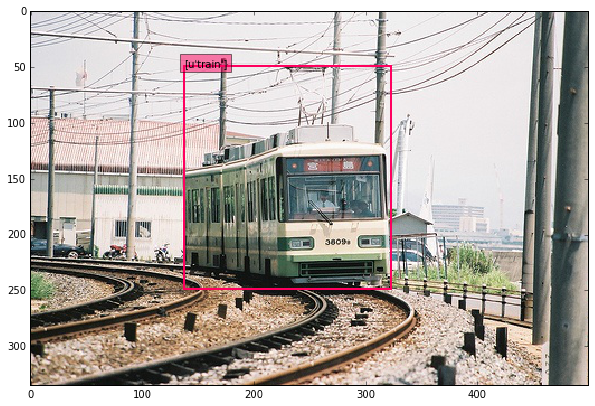

In [7]:
dic=_load_pascal_annotation('../data/VOCdevkit/VOC2007/Annotations/008710.xml')
pic = caffe.io.load_image('../data/VOCdevkit/VOC2007/JPEGImages/008710.jpg')
ano(pic,dic)

In [7]:
def con(image):
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    
    # Forward pass.
    # a=net.forward()
    # print(a)
    detections = net.forward()['detection_out']
    
    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    # print(det_conf)
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]
    
    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    print(get_labelname(labelmap, 13.0))
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    
    plt.imshow(image)
    currentAxis = plt.gca()
    
    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [8]:
def gen_box(image,m,n):
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    detections = net.forward()['detection_out']
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.92] 
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))+n
        ymin = int(round(top_ymin[i] * image.shape[0]))+m
        xmax = int(round(top_xmax[i] * image.shape[1]))+n
        ymax = int(round(top_ymax[i] * image.shape[0]))+m
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        color = colors[label]
        boxes.append([xmin,ymin,xmax,ymax,label,score])

In [10]:
boxes=[]
# set net to batch size of 1
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image('../high/011.jpg')
# plt.imshow(image)
ti=np.copy(image)
# plt.figure()

t100=np.zeros((20,20,400,400,3))
t200=np.zeros((20,20,600,600,3))

pixelmap=np.zeros((800,1200))

choose =1
if choose==1:
    ti=caffe.io.resize_image(ti,(800,800))
    for i in range(0,500,100):
        for j in range(0,500,100):
            t100[i/100,j/100]=ti[i:i+400,j:j+400]
    for i in range(0,300,100):
        for j in range(0,300,100):
            t200[i/100,j/100]=ti[i:i+600,j:j+600]
    gen_box(ti,0,0)
    for i in range(0,500,100):
        for j in range(0,500,100):
            gen_box(t100[i/100,j/100],i,j)
    for i in range(0,300,100):
        for j in range(0,300,100):
            gen_box(t200[i/100,j/100],i,j)
elif choose==2:
    ti=caffe.io.resize_image(ti,(800,1200))
    for i in range(0,500,100):
        for j in range(0,900,100):
            t100[i/100,j/100]=ti[i:i+400,j:j+400]
    for i in range(0,300,100):
        for j in range(0,700,140):
            t200[i/100,j/140]=ti[i:i+600,j:j+600]
    gen_box(ti,0,0)
    for i in range(0,500,100):
        for j in range(0,900,100):
            gen_box(t100[i/100,j/100],i,j)
    for i in range(0,300,100):
        for j in range(0,700,140):
            gen_box(t200[i/100,j/140],i,j)
else:
    gen_box(ti,0,0)
    ti=caffe.io.resize_image(ti,(1200,2000))
    for i in range(0,900,200):
        for j in range(0,1700,200):
            t100[i/200,j/200]=ti[i:i+400,j:j+400]
    for i in range(0,700,200):
        for j in range(0,1500,200):
            t200[i/200,j/200]=ti[i:i+600,j:j+600]
    for i in range(0,900,200):
        for j in range(0,1700,200):
            gen_box(t100[i/200,j/200],i,j)
    for i in range(0,700,200):
        for j in range(0,1500,200):
            gen_box(t200[i/200,j/200],i,j)
# t300=np.zeros((15,15,300,300,3))






def nvm2(boxes,overlapThresh):
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    pick=[]
    area=[]
    for (xmin,ymin,xmax,ymax,label,score) in boxes:
        x1.append(xmin)
        x2.append(xmax)
        y1.append(ymin)
        y2.append(ymax)
        area.append((xmax-xmin+1)*(ymax-ymin+1))
    idxs=np.argsort(y2)
#     objs=[]
#     for (xmin,ymin,xmax,ymax,label,score) in boxes:
#         area=(xmax-xmin+1)*(ymax-ymin+1)
#         objs.append((xmin,ymin,xmax,ymax),area,label,score)
    while len(idxs)>0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in xrange(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)              
        idxs = np.delete(idxs, suppress)
    nbox=[]
    for i in pick:
        nbox.append(boxes[i])
    return nbox
def nvm(boxes,overlapThresh,over2):
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    pick=[]
    area=[]
    for (xmin,ymin,xmax,ymax,label,score) in boxes:
        x1.append(xmin)
        x2.append(xmax)
        y1.append(ymin)
        y2.append(ymax)
        area.append((xmax-xmin+1)*(ymax-ymin+1))
    idxs=np.argsort(y2)
#     objs=[]
#     for (xmin,ymin,xmax,ymax,label,score) in boxes:
#         area=(xmax-xmin+1)*(ymax-ymin+1)
#         objs.append((xmin,ymin,xmax,ymax),area,label,score)
    while len(idxs)>0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in xrange(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > over2:
                suppress.append(pos)
            if overlap < overlapThresh and overlap > over2:
                boxes[i][0]=min(x1[i], x1[j])
                boxes[i][1]=min(y1[i], y1[j])
                boxes[i][2]=max(x2[i], x2[j])
                boxes[i][3]=max(y2[i], y2[j])                
        idxs = np.delete(idxs, suppress)
    nbox=[]
    for i in pick:
        nbox.append(boxes[i])
    return nbox

def delete1(boxes):
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    s=[]
    flag=np.zeros(len(boxes))
    for (xmin,ymin,xmax,ymax,label,score) in boxes:
        x1.append(xmin)
        x2.append(xmax)
        y1.append(ymin)
        y2.append(ymax)
        s.append(score)
    nbox=[]
    for i in range(len(boxes)):
        for j in range(len(boxes)):
            if (x1[i]>x1[j]-20 and x2[i]<x2[j]+20 and y1[i]>y1[j]-20 and y2[i]<y2[j]+35 and i!=j) or (x1[i]>x1[j]-20 and x2[i]<x2[j]+20 and y1[i]>y1[j]-35 and y2[i]<y2[j]+20 and i!=j) or (x1[i]>x1[j]-20 and x2[i]<x2[j]+35 and y1[i]>y1[j]-20 and y2[i]<y2[j]+20 and i!=j) or (x1[i]>x1[j]-35 and x2[i]<x2[j]+20 and y1[i]>y1[j]-20 and y2[i]<y2[j]+20 and i!=j):
                flag[i]=1
        if flag[i]==0:
            nbox.append(boxes[i])
    return nbox
            

def final(image):
    nnbox=nvm(boxes,0.8,0.5)
#     nnbox=nvm2(boxes,0.5)
    nbox=delete1(nnbox)
    print(len(nbox))
    plt.imshow(image)
    currentAxis = plt.gca()
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    for (xmin,ymin,xmax,ymax,label,score) in nbox:
        label_name=classes[label]
        display_txt = '%s: %.2f'%(label_name, score)
        color = colors[label]
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [11]:
image.shape

(815, 1226, 3)

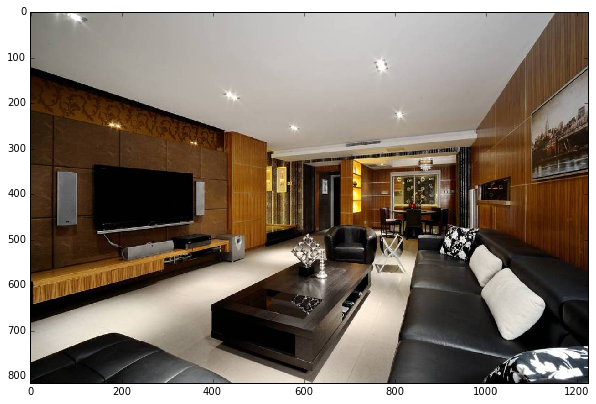

In [12]:
plt.imshow(image)

In [13]:
image1=caffe.io.resize_image(image,(300,600))

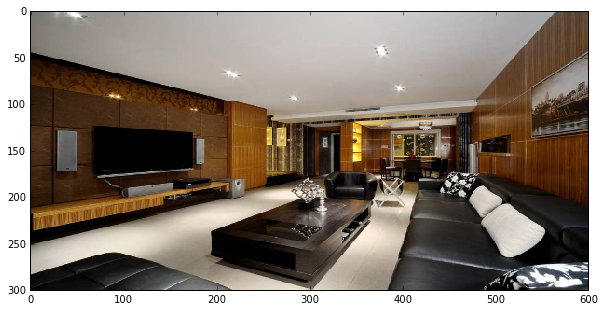

In [14]:
plt.imshow(image1)

2


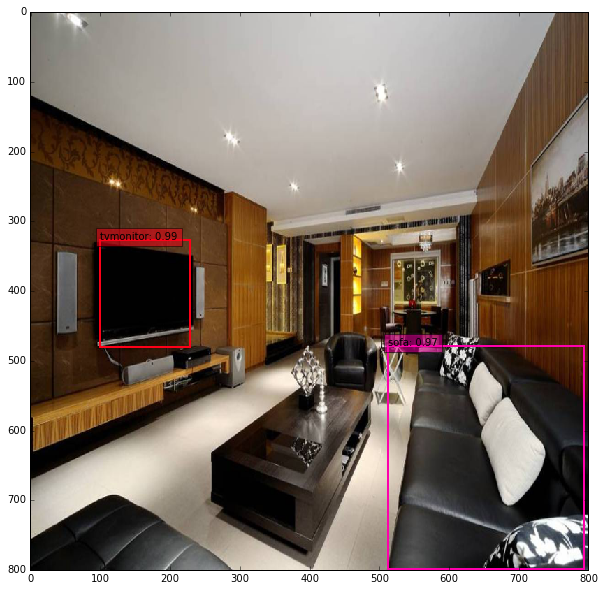

In [15]:
final(ti)

In [16]:
#  !cat ../data/VOCdevkit/VOC2007/Annotations/000005.xml

[u'horse']


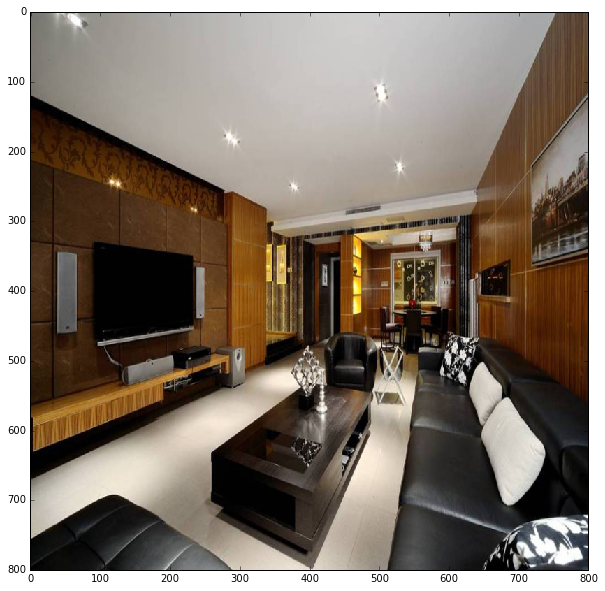

In [17]:
con(ti)

In [215]:
for i in range(0,700,200):
    print i

0
200
400
600
